In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn.metrics import classification_report
from skimage.restoration import denoise_wavelet
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout
from matplotlib.pyplot import figure
plt.rcParams['font.family'] = 'serif'

In [3]:
def denoise(df):
    x = np.array(df)
    x_denoise = denoise_wavelet(x,method = 'VisuShrink', mode='soft',wavelet_levels=8,wavelet='db4',rescale_sigma=True)

    return x_denoise

In [4]:
def conf_mat(act,pred,title):
  plt.figure(figsize=(10,8))
  class_labels = [0,1]
  conf= confusion_matrix(act, pred)
  ax = sns.heatmap(conf, annot = True,annot_kws={"fontsize": 19,"fontweight": "bold"}, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
  ax.tick_params(labelsize=15)
  plt.title(title, fontsize = 20)
  plt.ylabel('True label',fontsize = 15,fontweight="bold")
  plt.xlabel('Predicted label', fontsize = 15,fontweight="bold")
  filename = title + '.svg'
  plt.savefig(filename,format='svg',dpi=120)
  print(classification_report(act, pred))

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def pca_scaler(df):
  sc = StandardScaler()
  X= sc.fit_transform(df)
  pca = PCA(n_components = 2)
  X = pca.fit_transform(X)

  return X

In [6]:
def data_prep(df):

  df = df.loc[:,['Ax\n(m/s^2)',	'Ay\n(m/s^2)',	'Az\n(m/s^2)',	'Gx\n(deg/s)',	'Gy\n(deg/s)',	'Gz\n(deg/s)']]
  df.index = pd.date_range("0:00", freq="200ms", periods=len(df))

  for col in df.columns:
    df[col] = denoise(df[col])

  fig, ax = plt.subplots(figsize=(13,8))
  ax.plot(df.index,df.iloc[:,:])
  plt.show()

  for col in  df.columns:
    df[col] = df[col] -df[col].mean()
    df[col] = df[col].abs()


  return df

In [7]:
from sklearn.neighbors import LocalOutlierFactor

def lof_(X,neighbor=100,cont=0.04):
  lof = LocalOutlierFactor(n_neighbors=neighbor, novelty=True, contamination=cont)
  lof.fit(X)
  pred = lof.predict(X)
  outlier_index = np.where(pred==-1)
  outlier_values = X[outlier_index]
  # Plot the data
  sns.scatterplot(x=X[:,0], y=X[:,1])
  sns.scatterplot(x=outlier_values[:,0], y=outlier_values[:,1], color='r')
  plt.title("LOF Outlier Detection", fontsize=15, pad=15)

  return lof,pred,outlier_values

In [8]:
def lof_pred(lof,X):
  pred = lof.predict(X)
  outlier_index = np.where(pred==-1)
  outlier_values = X[outlier_index]
  # Plot the data
  sns.scatterplot(x=X[:,0], y=X[:,1])
  sns.scatterplot(x=outlier_values[:,0], y=outlier_values[:,1], color='r')
  plt.title("LOF Outlier Detection", fontsize=15, pad=15)

  return lof,pred,outlier_values

In [9]:
from sklearn.svm import OneClassSVM

def one_class_svm(X,kernel='rbf', gamma=0.01, nu=0.04):
  svm = OneClassSVM(kernel=kernel, gamma=gamma, nu=nu)
  pred = svm.fit_predict(X)
  scores = svm.score_samples(X)
  thresh = np.quantile(scores, 0.04)
  index = np.where(scores<=thresh)
  values = X[index]
  plt.scatter(X[:,0], X[:,1])
  plt.scatter(values[:,0], values[:,1], color='r')
  plt.show()
  return svm, pred, scores, thresh, index, values

In [10]:
def svm_pred(svm,thresh,X):
  pred = svm.predict(X)
  scores = svm.score_samples(X)
  index = np.where(scores<=thresh)
  values = X[index]
  plt.scatter(X[:,0], X[:,1])
  plt.scatter(values[:,0], values[:,1], color='r')
  plt.show()

  return pred, scores, index, values

In [11]:
def plot_df(df):
  cdict={1:'red',0:'black'}
  scatter_y = np.array(df.iloc[:,-2])
  #scatter_x = np.array([*range(len(df_anomaly))])
  scatter_x = df.index

  fig, ax = plt.subplots(figsize=(15,10))
  for g in np.unique(df['label']):
    ix = np.where(df['label'] == g)
    if g == 1:
      ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g],  s = 20, label='outlier')
    else:
      ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g],  s = 10, alpha=0.09,label='normal')
  ax.legend()
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.show()

In [12]:
def svm_plot(df):
  cdict={-1:'red',1:'black'}
  scatter_y = np.array(df.iloc[:,0])
  #scatter_x = np.array([*range(len(df_anomaly))])
  scatter_x = df.index
  fig, ax = plt.subplots()
  for g in np.unique(pred):
    ix = np.where(pred == g)
    if g == -1:
      ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g],  s = 20, label='outlier')
    else:
      ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g],  s = 10, alpha=0.09,label='normal')
  ax.legend()
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.show()

In [13]:
def create_data(df):
  segments = []
  labels = []

  for i in range(0,  df.shape[0]- n_time_steps, step):

      xs = df['Ax\n(m/s^2)'].values[i: i + n_time_steps]

      ys = df['Ay\n(m/s^2)'].values[i: i + n_time_steps]

      zs = df['Az\n(m/s^2)'].values[i: i + n_time_steps]

      gxs = df['Gx\n(deg/s)'].values[i: i + n_time_steps]

      gys = df['Gy\n(deg/s)'].values[i: i + n_time_steps]

      gzs = df['Gz\n(deg/s)'].values[i: i + n_time_steps]

      label = stats.mode(df['label'][i: i + n_time_steps])[0]

      segments.append([xs, ys, zs, gxs, gys, gzs])

      labels.append(label)

  reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)
  labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

  return reshaped_segments, labels

In [14]:
def create_model(rnn_layer = 128, dropout=0.5,relu_layer=64):
  model = Sequential()
# RNN layer
  model.add(LSTM(units = rnn_layer, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
  model.add(Dropout(dropout))
# Dense layer with ReLu
  model.add(Dense(units = relu_layer, activation='relu'))
# Softmax layer
  model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [15]:
def train_model(model,X_train,y_train,n_epochs,batch_size):
  history = model.fit(X_train, y_train, epochs = n_epochs, validation_split = 0.33, batch_size = batch_size, verbose = 1)
  # plt.figure(figsize=(25,20))
  fig, ax = plt.subplots(figsize=(20,15))
  ax.plot(np.array(history.history['loss']), "r--", label = "Train loss")
  ax.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
  ax.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
  ax.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
  ax.set_title("Training session's progress over iterations",fontsize=30,fontweight='bold')
  ax.legend(loc='lower left',prop={'size': 25,'weight':'bold'})
  ax.set_ylabel('Training Progress (Loss/Accuracy)',fontsize=22,fontweight='bold')
  ax.set_xlabel('Training Epoch',fontsize=22,fontweight='bold')
  ax.set_xticklabels(ax.get_xticks(), weight='bold',fontsize=15)
  ax.set_yticklabels(ax.get_yticks(), weight='bold',fontsize=15)
  # ax.ylim(0)
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
  plt.savefig('Train_loss.svg',format='svg',dpi=200)
  plt.savefig('Train_loss.png',format='png',dpi=200)
  return history,model

In [16]:
df2 = pd.read_csv('../data/normalbenchy.csv')
df1 = pd.read_csv('../data/benchydefect.csv')
#df = pd.read_csv('/content/run_1_again.csv')

In [17]:
df = pd.read_csv('../data/SensorDataFile.csv')
df = df.iloc[:,3:-1]

In [18]:
px.histogram(df)

In [18]:
df['new label'] = 0
df.loc[df['Gz\n(deg/s)'] > 0.13, 'new label'] = 1

In [19]:
df = df[df['label']==1].iloc[:,:-1]

In [20]:
df

,Ax\n(m/s^2),Ay\n(m/s^2),Az\n(m/s^2),Gx\n(deg/s),Gy\n(deg/s),Gz\n(deg/s)
20,1.419762,1.438915,9.315839,0.343511,0.358779,0.419847
42,-0.323217,0.208296,10.872070,0.198473,1.244275,0.175573
100,-8.932766,5.087679,16.713922,-0.045802,-13.068702,0.442748
102,2.195483,3.035848,6.548142,-0.091603,5.870229,1.595420
110,8.992621,0.474052,-0.574608,-0.137405,8.503817,0.656489
...,...,...,...,...,...,...
7805,0.768539,1.553837,8.916007,0.007634,0.625954,0.862595
7835,0.308852,0.679953,9.983821,0.129771,-1.900763,0.366412
7886,1.079785,1.027113,9.758766,0.114504,-2.496183,0.305344
7942,-0.581791,0.126893,10.632650,1.923664,2.312977,0.885496


In [21]:
df1 = pd.concat([df1, df], ignore_index=True, sort=False)
df1

,Date\n(YY:MM:DD),Time\n(HH:MM:SS),Time\n(µs),Ax\n(m/s^2),Ay\n(m/s^2),Az\n(m/s^2),Gx\n(deg/s),Gy\n(deg/s),Gz\n(deg/s),label
0,05-12-22,16:58:08,961355.0,4.261679,1.235408,11.578359,-0.198473,2.190840,-0.083969,0.0
1,05-12-22,16:58:09,173344.0,4.328717,0.840365,8.896853,0.183206,3.702290,-2.122137,0.0
2,05-12-22,16:58:09,385342.0,2.528277,-0.727837,7.680599,0.419847,3.282443,0.068702,0.0
3,05-12-22,16:58:09,597567.0,-3.354277,2.078167,14.894329,0.183206,-6.709924,-2.183206,0.0
4,05-12-22,16:58:09,809555.0,4.750096,-0.335188,10.594342,0.587786,2.732824,-1.045802,0.0
...,...,...,...,...,...,...,...,...,...,...
5561,NaN,NaN,NaN,0.768539,1.553837,8.916007,0.007634,0.625954,0.862595,NaN
5562,NaN,NaN,NaN,0.308852,0.679953,9.983821,0.129771,-1.900763,0.366412,NaN
5563,NaN,NaN,NaN,1.079785,1.027113,9.758766,0.114504,-2.496183,0.305344,NaN
5564,NaN,NaN,NaN,-0.581791,0.126893,10.632650,1.923664,2.312977,0.885496,NaN


In [22]:
df1.describe()

,Time\n(µs),Ax\n(m/s^2),Ay\n(m/s^2),Az\n(m/s^2),Gx\n(deg/s),Gy\n(deg/s),Gz\n(deg/s),label
count,5088.000000,5566.000000,5566.000000,5566.000000,5566.000000,5566.000000,5566.000000,5088.000000
mean,499316.591981,0.439279,0.474849,9.949687,0.016663,-0.249327,-0.691047,0.095912
std,288711.440813,1.713850,0.811902,1.464685,0.362665,2.614336,2.022831,0.294499
min,81.000000,-19.613300,-5.600038,-19.613300,-5.503817,-31.488550,-32.587786,0.000000
25%,248413.500000,-0.203507,0.127491,9.497798,-0.122137,-1.082061,-1.320611,0.000000
50%,498048.500000,0.447716,0.457293,9.950302,0.022901,-0.213740,-0.824427,0.000000
75%,750763.000000,1.106121,0.792481,10.419566,0.152672,0.702290,-0.251908,0.000000
max,999953.000000,19.612701,19.503167,19.612701,4.580153,35.198473,27.045802,1.000000


In [23]:
df2.describe()

,Time\n(µs),Ax\n(m/s^2),Ay\n(m/s^2),Az\n(m/s^2),Gx\n(deg/s),Gy\n(deg/s),Gz\n(deg/s),label
count,7987.000000,7987.000000,7987.000000,7987.000000,7987.000000,7987.000000,7987.000000,7987.0
mean,500328.856392,0.475230,0.417601,9.899028,0.001614,-0.247730,-0.906370,0.0
std,288653.980079,1.337383,0.548066,1.270758,0.306945,1.989989,0.741304,0.0
min,54.000000,-13.081918,-4.809951,-11.257536,-1.954198,-25.015267,-5.244275,0.0
25%,251215.000000,-0.050278,0.155623,9.502586,-0.129771,-0.938931,-1.305344,0.0
50%,501809.000000,0.469264,0.418985,9.916783,0.007634,-0.259542,-0.908397,0.0
75%,748115.500000,1.019930,0.670376,10.326192,0.129771,0.442748,-0.511450,0.0
max,999824.000000,14.154520,5.700594,19.612701,1.946565,23.679389,3.900763,0.0


In [24]:
fft = np.fft.fft((df2['Ax\n(m/s^2)']-df2['Ax\n(m/s^2)'].mean()))
freqs = np.fft.fftfreq(len(fft)) * 5
print(np.argmax(np.abs(fft)))
freq = freqs[np.argmax(np.abs(fft))]

print("Frequency: {} Hz".format(freq))

fft = np.fft.fft((df2['Ay\n(m/s^2)']-df2['Ay\n(m/s^2)'].mean()))
freqs = np.fft.fftfreq(len(fft)) * 5
freq = freqs[np.argmax(np.abs(fft))]
print(np.argmax(np.abs(fft)))
print("Frequency: {} Hz".format(freq))

fft = np.fft.fft((df2['Az\n(m/s^2)']-df2['Az\n(m/s^2)'].mean()))
freqs = np.fft.fftfreq(len(fft)) * 5
freq = freqs[np.argmax(np.abs(fft))]
print(np.argmax(np.abs(fft)))
print("Frequency: {} Hz".format(freq))

3981
Frequency: 2.492174784024039 Hz
3709
Frequency: 2.3218980843871293 Hz
6044
Frequency: -1.2163515713033681 Hz


In [25]:
 np.fft.fft(df2.loc[1000:,'Ax\n(m/s^2)'])

array([ 3.34270056e+03 +0.j        ,  2.18521132e+00-59.81642573j,
        3.43924345e+01+54.15925912j, ..., -9.70301197e+01+48.21541213j,
        3.43924345e+01-54.15925912j,  2.18521132e+00+59.81642573j])

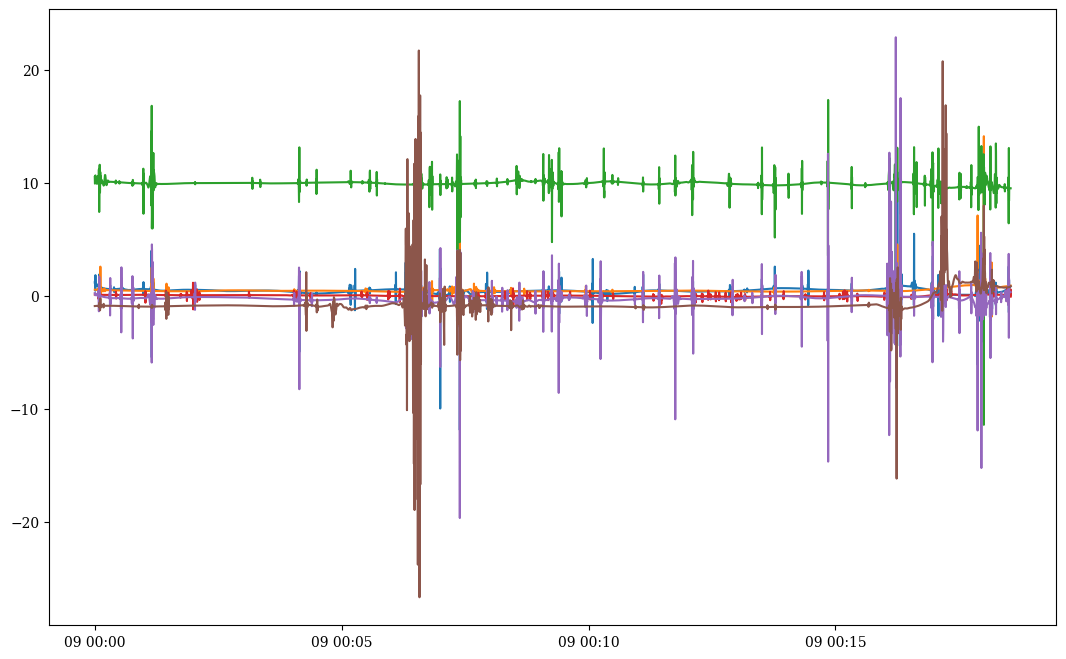

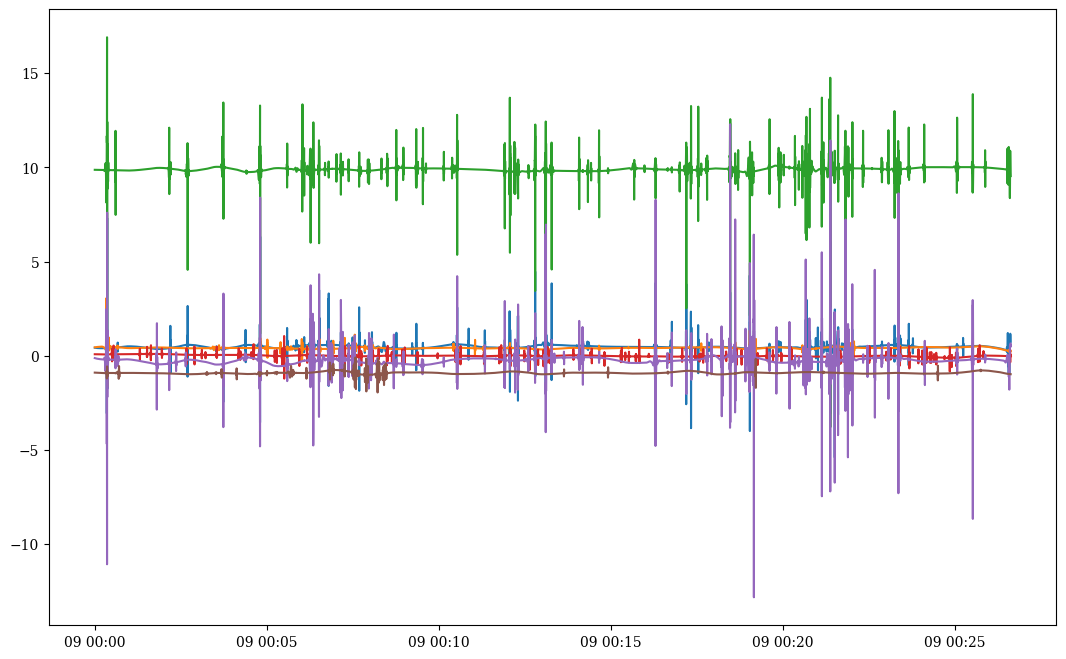

In [ ]:
df1 = data_prep(df1)
print('\n')
df2 = data_prep(df2)

In [ ]:
X1 = pca_scaler(df1)
X2 = pca_scaler(df2)

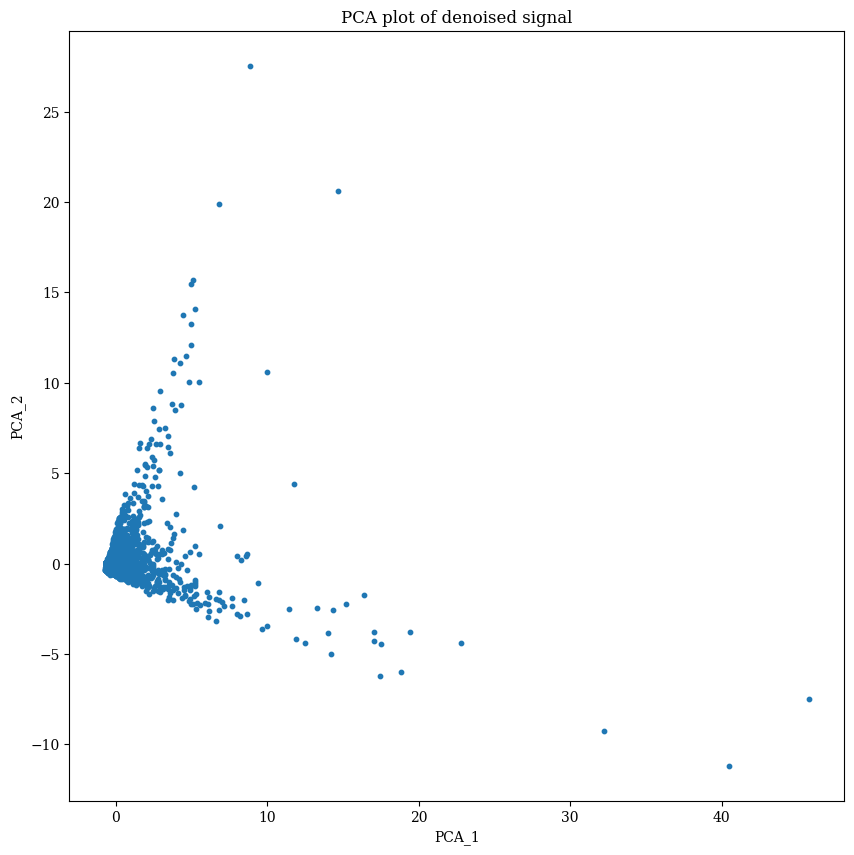

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams['font.family'] = 'serif'
plt.scatter(X1[:,0],X1[:,1],s=10)
plt.title('PCA plot of denoised signal')
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.show()

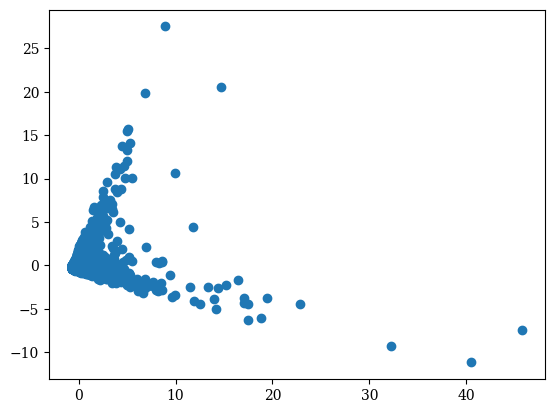

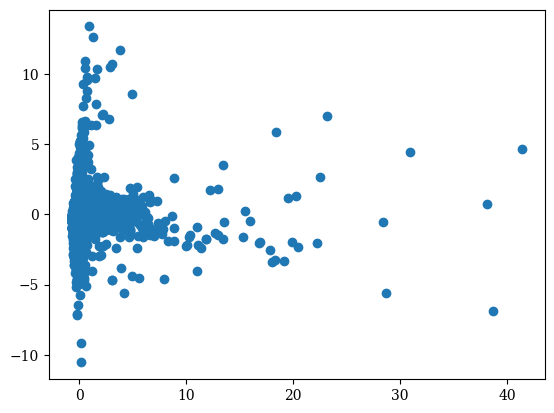

In [ ]:
plt.scatter(X1[:,0],X1[:,1])
plt.show()
plt.scatter(X2[:,0],X2[:,1])
plt.show()

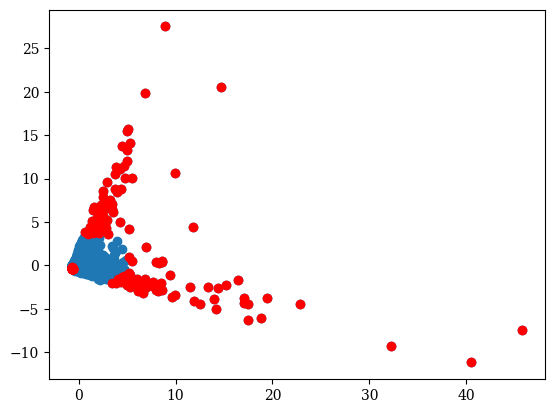

In [ ]:
svm, train_pred, scores, thresh, index, values_1 = one_class_svm(X1)

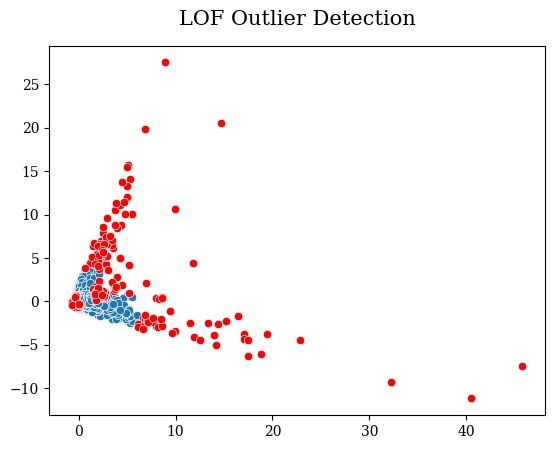

In [ ]:
lof,train_pred_lof,values_1_lof = lof_(X1)

In [ ]:
thresh

152.31743967419055

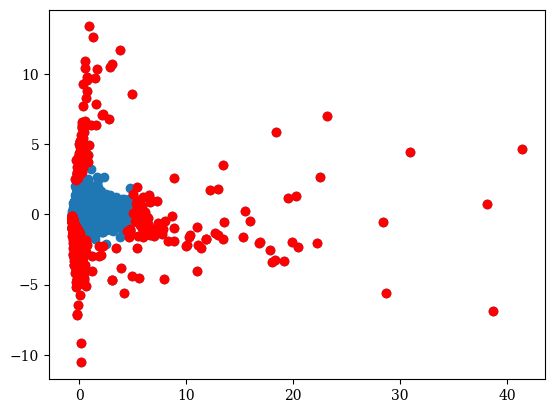

In [ ]:
pred, scores_2, index_2,values_2 = svm_pred(svm,thresh,X2)

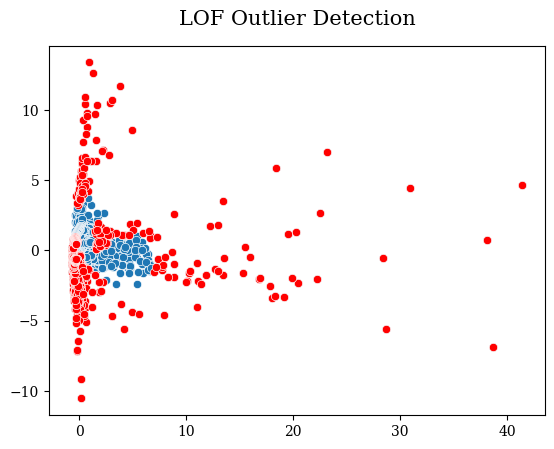

In [ ]:
lof,pred_lof,values_2_lof = lof_pred(lof,X2)

In [ ]:
px.histogram(df1)

In [ ]:
df1['label'] = 0
df1.loc[df1['Gz\n(deg/s)'] > 0.24, 'label'] = 1

df2['label'] = 0
#df2.loc[df2['Gz\n(deg/s)'] > 0.13, 'label'] = 1

In [ ]:
print('Labels for training: ')
print( 'Normal ', len(df1[df1['label']==0]))
print('Outlier', len(df1[df1['label']==1]))
print('% outliers: ', (len(df1[df1['label']==1])/len(df1['label']))*100)
print('Labels for testing: ')
print( 'Normal ', len(df2[df2['label']==0]))
print('Outlier', len(df2[df2['label']==1]))
print('% outliers: ', (len(df2[df2['label']==1])/len(df2['label']))*100)

Labels for training: 
Normal  2922
Outlier 2644
% outliers:  47.50269493352498
Labels for testing: 
Normal  7987
Outlier 0
% outliers:  0.0


In [ ]:
train_pred[np.where(train_pred==1)]=0
train_pred[np.where(train_pred==-1)]=1
train_pred_lof[np.where(train_pred_lof==1)]=0
train_pred_lof[np.where(train_pred_lof==-1)]=1

In [ ]:
pred[np.where(pred==1)]=0
pred[np.where(pred==-1)]=1
pred_lof[np.where(pred_lof==1)]=0
pred_lof[np.where(pred_lof==-1)]=1

Training Data plot


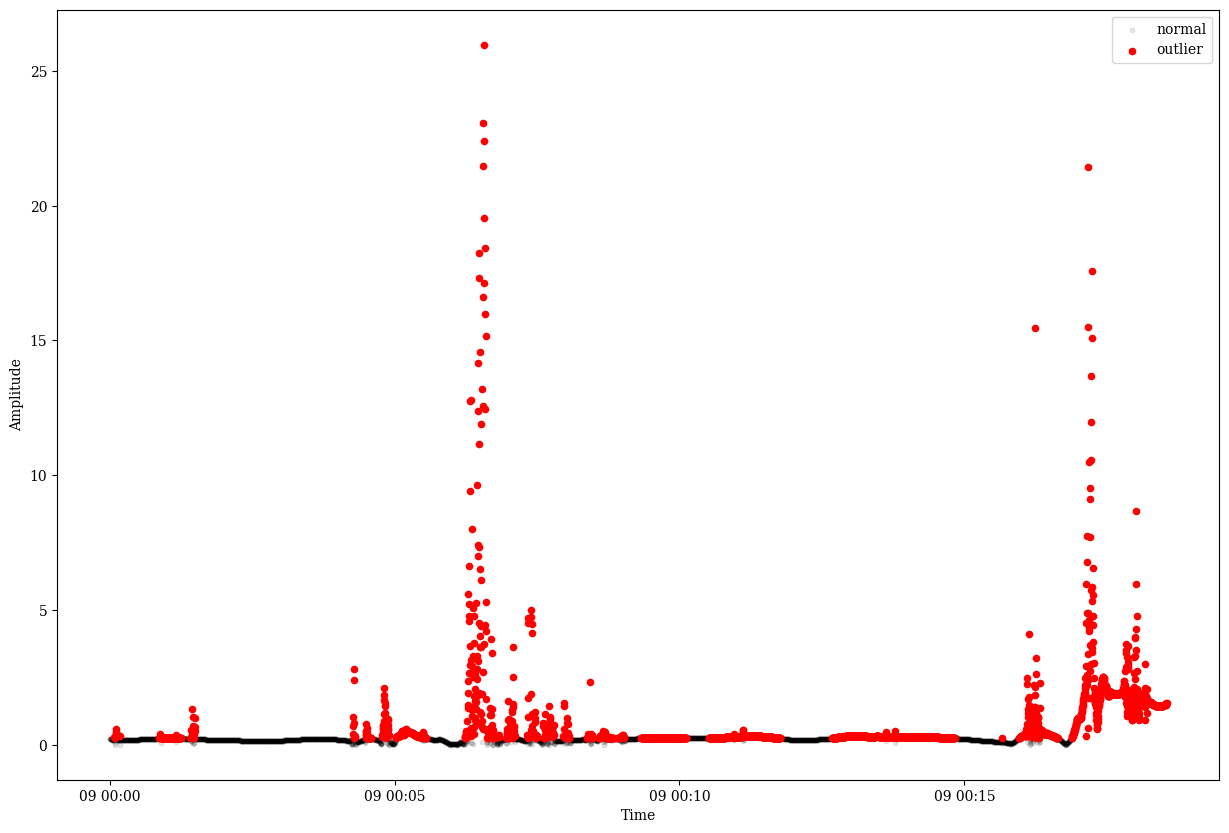


Testing Data plot


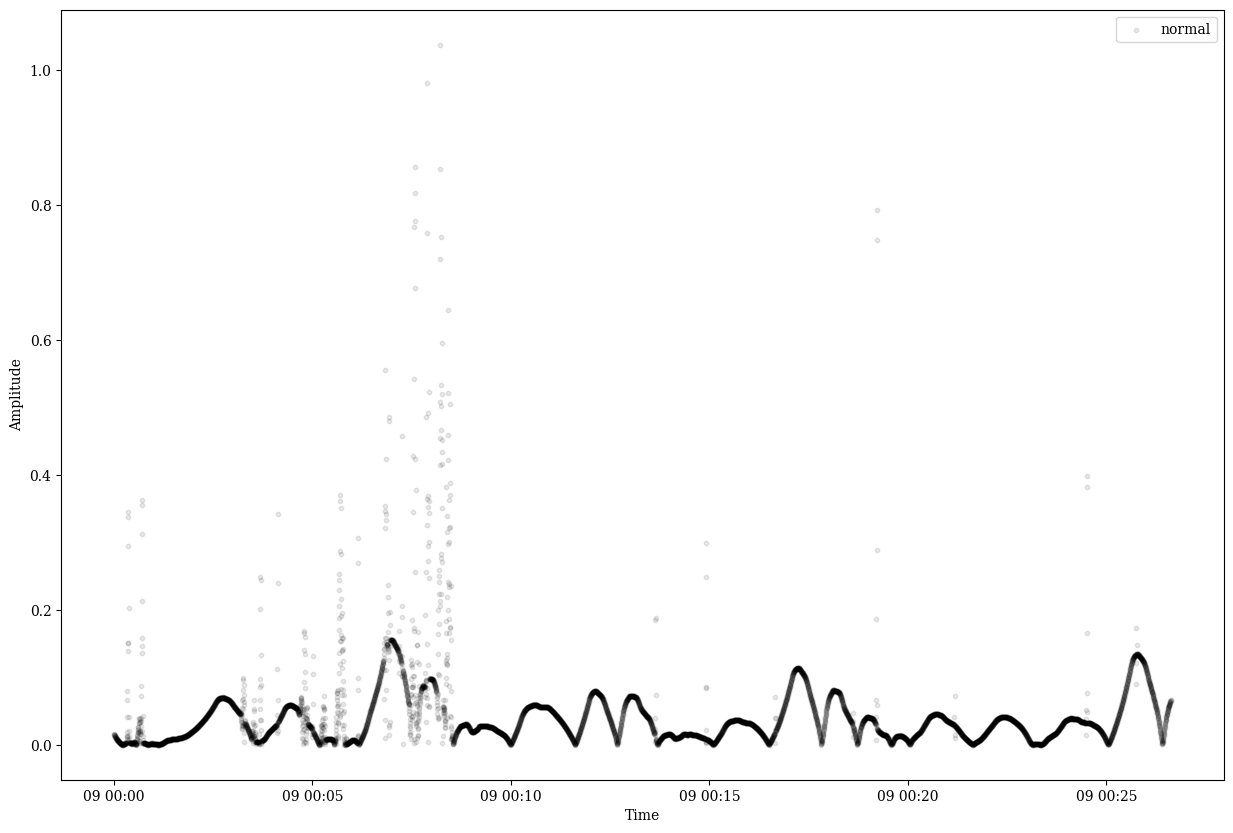

In [ ]:
print('Training Data plot')
plot_df(df1)

print('\nTesting Data plot')
plot_df(df2)

Confusion matrix and metrics for training data

              precision    recall  f1-score   support

           0       0.54      0.99      0.70      2922
           1       0.84      0.07      0.13      2644

    accuracy                           0.55      5566
   macro avg       0.69      0.53      0.41      5566
weighted avg       0.68      0.55      0.43      5566


Confusion matrix and metrics for testing data



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       1.00      0.88      0.94      7987
           1       0.00      0.00      0.00         0

    accuracy                           0.88      7987
   macro avg       0.50      0.44      0.47      7987
weighted avg       1.00      0.88      0.94      7987

Confusion matrix and metrics for training data

              precision    recall  f1-score   support

           0       0.54      0.98      0.70      2922
           1       0.79      0.07      0.12      2644

    accuracy                           0.55      5566
   macro avg       0.67      0.53      0.41      5566
weighted avg       0.66      0.55      0.42      5566

Confusion matrix and metrics for tesing data

              precision    recall  f1-score   support

           0       1.00      0.78      0.87      7987
           1       0.00      0.00      0.00         0

    accuracy                           0.78      7987
   macro avg       0.50      0.39 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



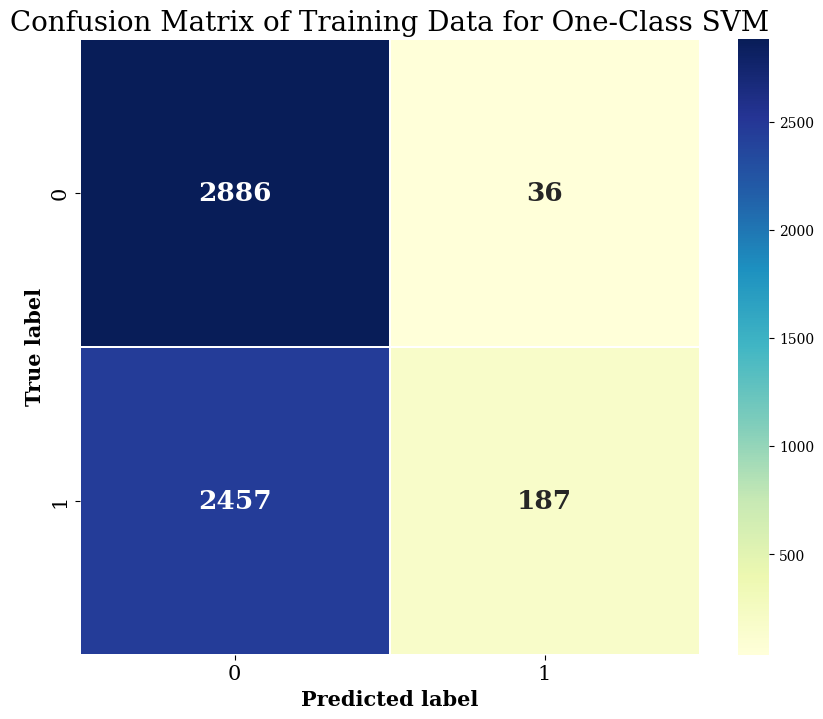

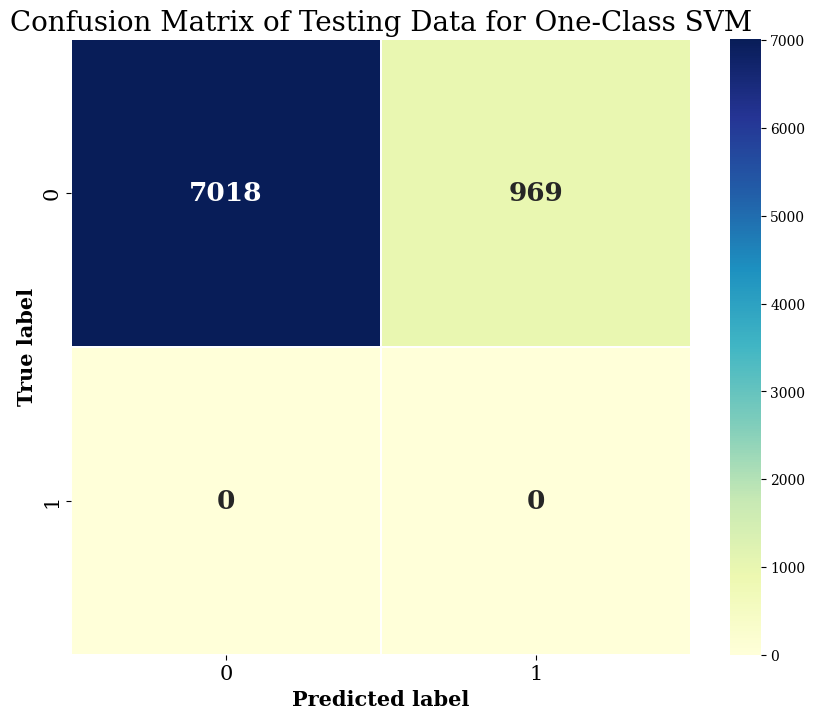

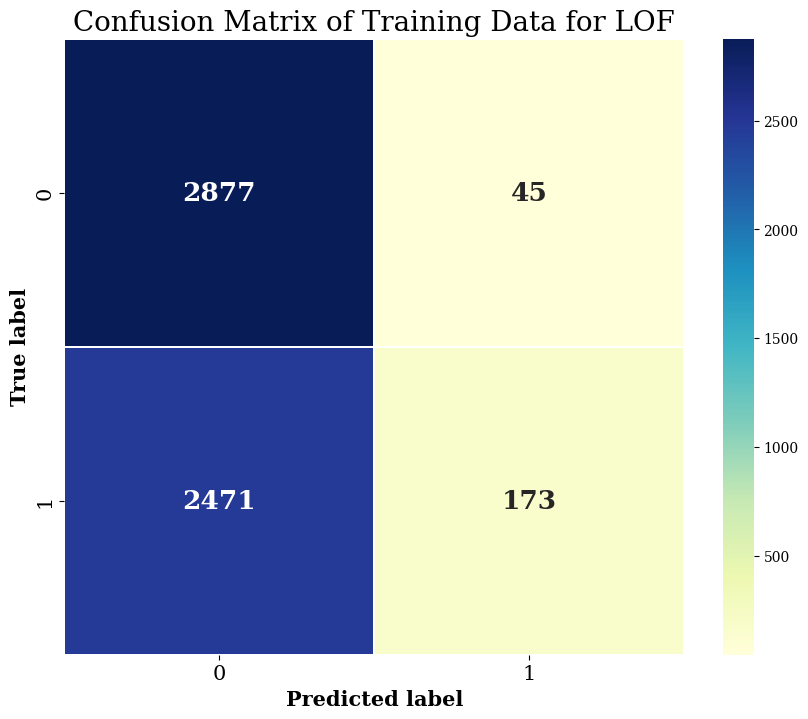

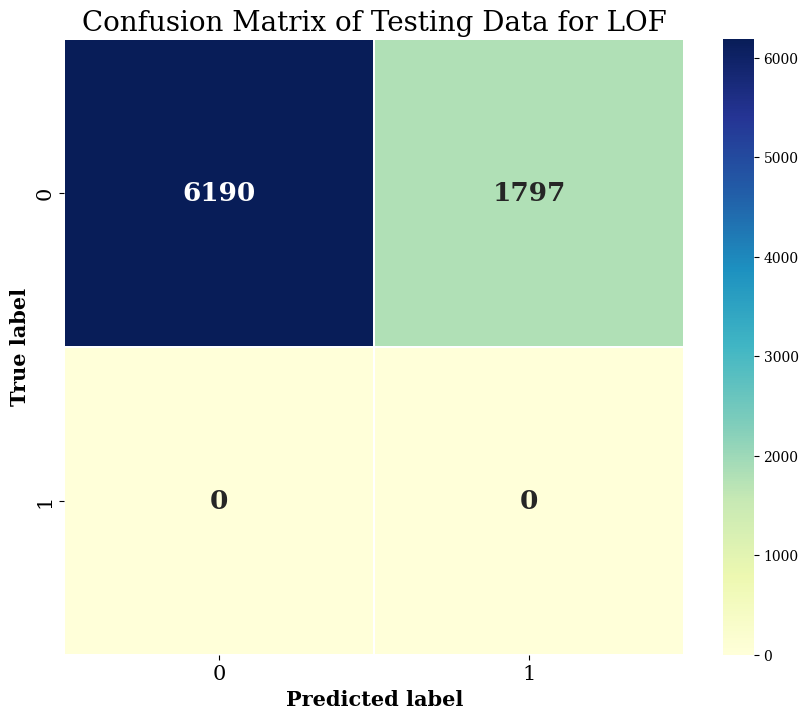

In [ ]:
print('Confusion matrix and metrics for training data\n')
conf_mat(df1['label'],train_pred,"Confusion Matrix of Training Data for One-Class SVM")

print('\nConfusion matrix and metrics for testing data\n')
conf_mat(df2['label'],pred,"Confusion Matrix of Testing Data for One-Class SVM")

print('Confusion matrix and metrics for training data\n')
conf_mat(df1['label'],train_pred_lof,"Confusion Matrix of Training Data for LOF")

print('Confusion matrix and metrics for tesing data\n')
conf_mat(df2['label'],pred_lof,"Confusion Matrix of Testing Data for LOF")


In [ ]:
random_seed = 42
n_time_steps = 10
n_features = 6
step = 2
n_classes = 2
n_epochs = 200
batch_size =  2048
learning_rate = 0.000025
l2_loss = 0.000015

In [ ]:
reshaped_segments_1, labels_1 = create_data(df1)
reshaped_segments_2, labels_2 = create_data(df2)

<ipython-input-12-cdc0dc089457>:19: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments_1, labels_1, test_size = 0.33, random_state = random_seed)
#X_train = reshaped_segments_1
#X_test = reshaped_segments_2
#y_train = labels_1
#y_test = labels_2

In [ ]:
model = create_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128)               69120     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 2)                 130       
                                                                 
Total params: 77,506
Trainable params: 77,506
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.6919 - accuracy: 0.4896 - val_loss: 0.6840 - val_accuracy: 0.6114
Epoch 2/200
1/1 [==============================] - 0s 196ms/step - loss: 0.6812 - accuracy: 0.5281 - val_loss: 0.6713 - val_accuracy: 0.5545
Epoch 3/200
1/1 [==============================] - 0s 200ms/step - loss: 0.6711 - accuracy: 0.5337 - val_loss: 0.6596 - val_accuracy: 0.5106
Epoch 4/200
1/1 [==============================] - 0s 188ms/step - loss: 0.6610 - accuracy: 0.5225 - val_loss: 0.6496 - val_accuracy: 0.4943
Epoch 5/200
1/1 [==============================] - 0s 218ms/step - loss: 0.6539 - accuracy: 0.5032 - val_loss: 0.6410 - val_accuracy: 0.4959
Epoch 6/200
1/1 [==============================] - 0s 226ms/step - loss: 0.6479 - accuracy: 0.5096 - val_loss: 0.6336 - val_accuracy: 0.5089
Epoch 7/200
1/1 [==============================] - 0s 209ms/step - loss: 0.6407 - accuracy: 0.5209 - val_loss: 0.6272 - val_accuracy: 0.5301
Epoch 8/200
1/1 

<ipython-input-66-45f91717b6da>:13: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-66-45f91717b6da>:14: UserWarning:

FixedFormatter should only be used together with FixedLocator



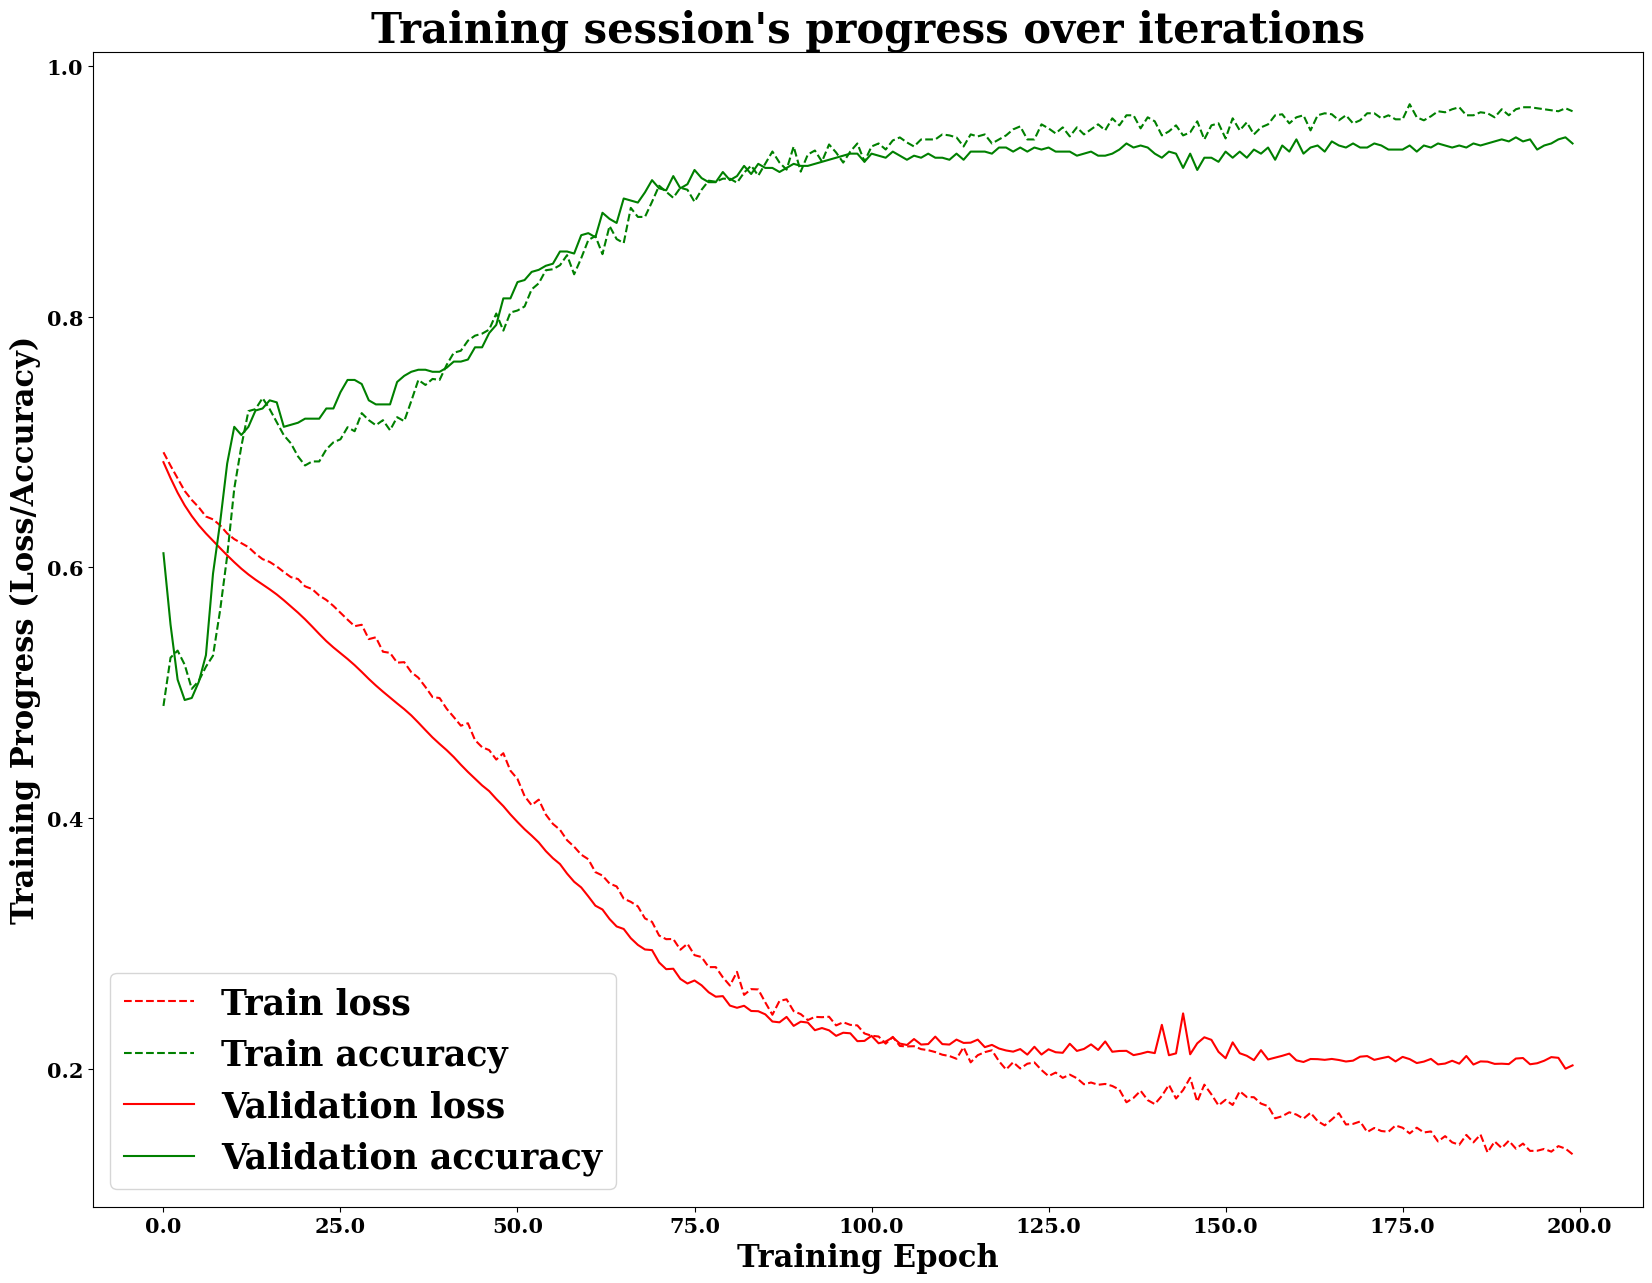

In [ ]:
from matplotlib.ticker import FormatStrFormatter
history,model  = train_model(model,X_train,y_train,n_epochs,batch_size)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

1/1 [==============================] - 0s 80ms/step - loss: 0.2818 - accuracy: 0.9193
Test Accuracy : 0.9193020462989807
Test Loss : 0.2818228304386139


59/59 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       981
           1       0.95      0.95      0.95       880

    accuracy                           0.95      1861
   macro avg       0.95      0.95      0.95      1861
weighted avg       0.95      0.95      0.95      1861



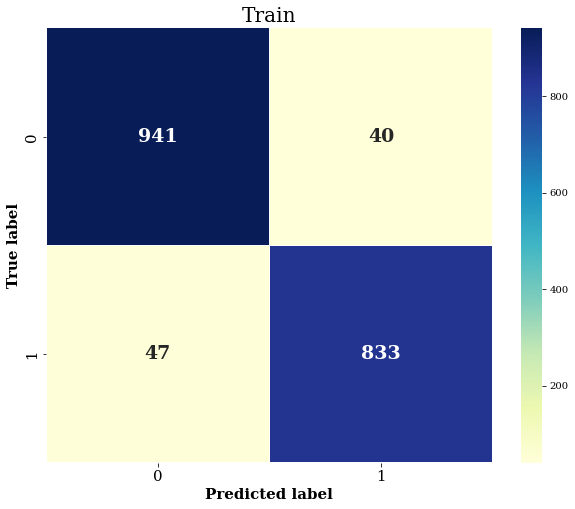

In [ ]:
train_predictions = model.predict(X_train)
max_test = np.argmax(y_train, axis=1)
max_train_predictions = np.argmax(train_predictions, axis=1)
conf_mat(max_test, max_train_predictions,'Train')

29/29 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       482
           1       0.94      0.89      0.91       435

    accuracy                           0.92       917
   macro avg       0.92      0.92      0.92       917
weighted avg       0.92      0.92      0.92       917



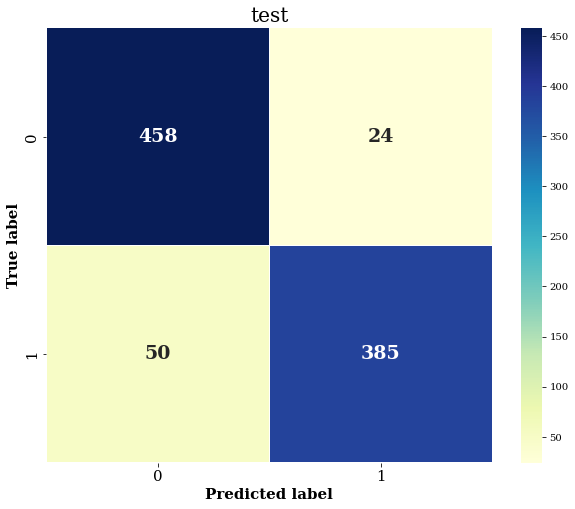

In [ ]:
test_predictions = model.predict(X_test)
max_test = np.argmax(y_test, axis=1)
max_test_predictions = np.argmax(test_predictions, axis=1)
conf_mat(max_test, max_test_predictions,'test')

In [ ]:
predictions = model.predict(reshaped_segments_1)

87/87 [==============================] - 1s 6ms/step


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1463
           1       0.95      0.93      0.94      1315

    accuracy                           0.94      2778
   macro avg       0.94      0.94      0.94      2778
weighted avg       0.94      0.94      0.94      2778



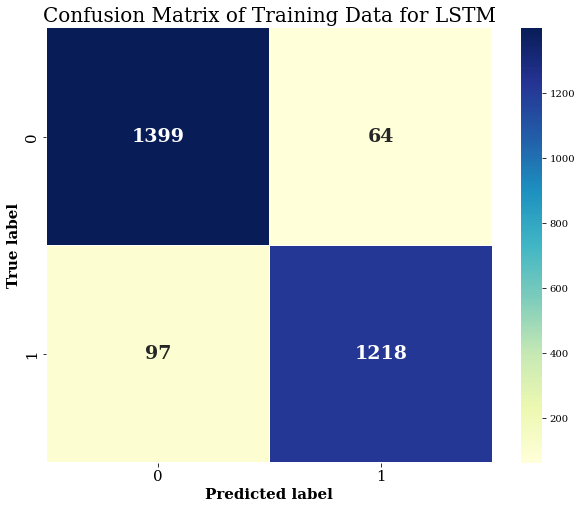

In [ ]:
max_act = np.argmax(labels_1,axis=1)
max_pred = np.argmax(predictions,axis=1)
conf_mat(max_act,max_pred,"Confusion Matrix of Training Data for LSTM")

In [ ]:
predictions = model.predict(reshaped_segments_2)

125/125 [==============================] - 1s 6ms/step


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3989
           1       0.00      0.00      0.00         0

    accuracy                           0.98      3989
   macro avg       0.50      0.49      0.50      3989
weighted avg       1.00      0.98      0.99      3989



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



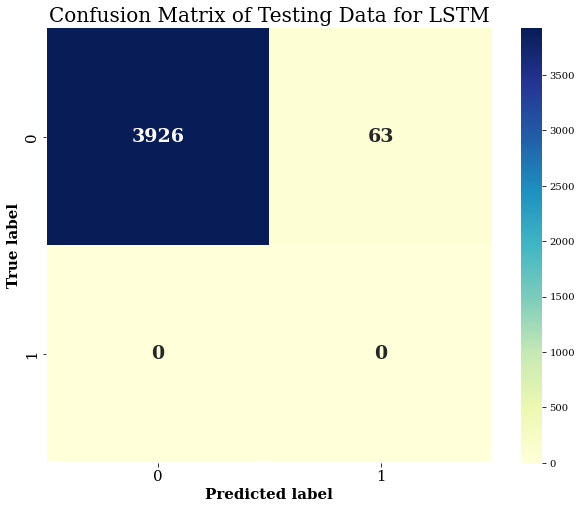

In [ ]:
max_act = np.argmax(labels_2,axis=1)
max_pred = np.argmax(predictions,axis=1)
conf_mat(max_act,max_pred,"Confusion Matrix of Testing Data for LSTM")

In [ ]:
X = df1.iloc[:,:-1]
y = df1.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

svc=SVC()


# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.8960


In [ ]:
X = df1.iloc[:,:-1]
X_svc = scaler.transform(X)

In [ ]:
pred_svc = svc.predict(X_svc)

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2922
           1       0.94      0.83      0.88      2644

    accuracy                           0.89      5566
   macro avg       0.90      0.89      0.89      5566
weighted avg       0.90      0.89      0.89      5566



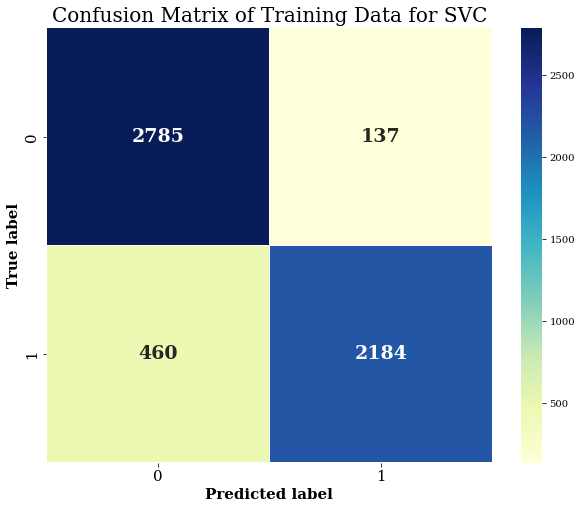

In [ ]:
conf_mat(df1['label'],pred_svc,"Confusion Matrix of Training Data for SVC")

In [ ]:
X = df2.iloc[:,:-1]
X_svc = scaler.transform(X)

In [ ]:
pred_svc = svc.predict(X_svc)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7987
           1       0.00      0.00      0.00         0

    accuracy                           0.98      7987
   macro avg       0.50      0.49      0.49      7987
weighted avg       1.00      0.98      0.99      7987



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



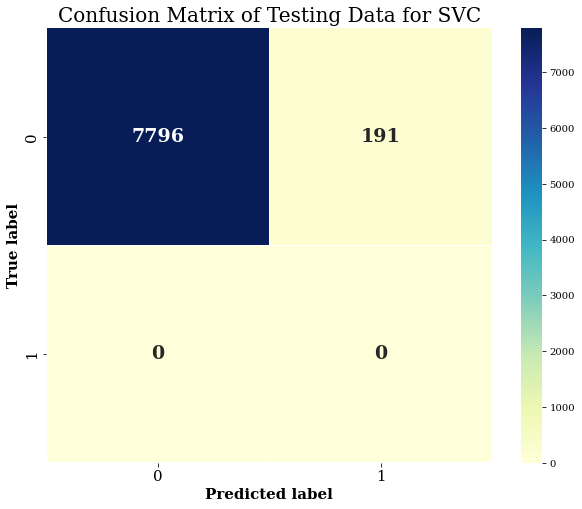

In [ ]:
conf_mat(df2['label'],pred_svc,"Confusion Matrix of Testing Data for SVC")

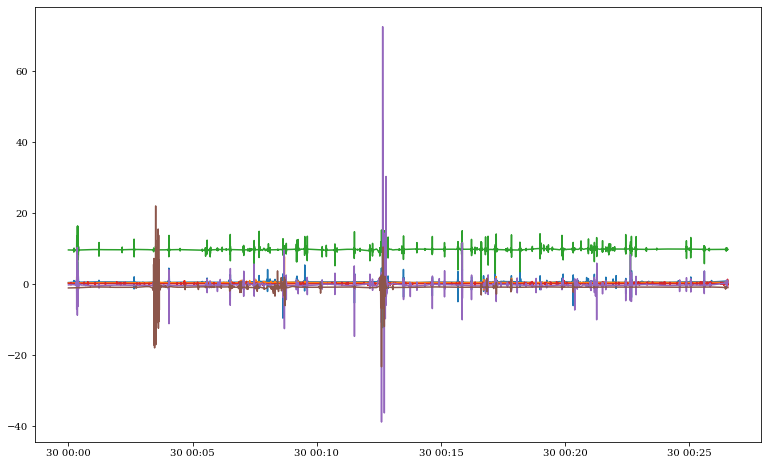

In [ ]:
df3 = pd.read_csv('../data/SensorDataFile.csv')
df3 = data_prep(df3)

In [ ]:
X3 = pca_scaler(df3)

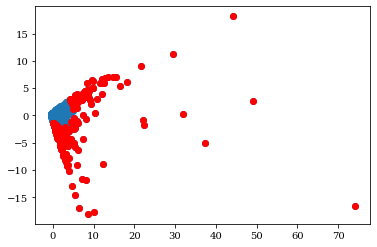

In [ ]:
pred_3, scores_3, index_3,values_3 = svm_pred(svm,thresh,X3)

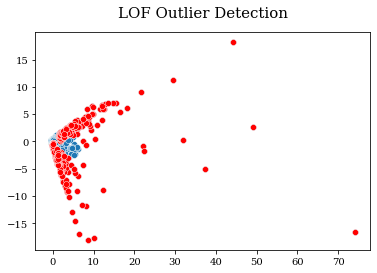

In [ ]:
lof,lof_pred_3,values_3_lof = lof_pred(lof,X3)

In [ ]:
df3['label'] = 0
df3.loc[df3['Gz\n(deg/s)'] > 0.24, 'label'] = 1

In [ ]:
print('Labels for new data: ')
print( 'Normal ', len(df3[df3['label']==0]))
print('Outlier', len(df3[df3['label']==1]))
print('% outliers: ', (len(df3[df3['label']==1])/len(df3['label']))*100)

Labels for new data: 
Normal  7562
Outlier 405
% outliers:  5.0834693109074935


In [ ]:
pred_3[np.where(pred_3==1)]=0
pred_3[np.where(pred_3==-1)]=1
lof_pred_3[np.where(lof_pred_3==1)]=0
lof_pred_3[np.where(lof_pred_3==-1)]=1

Unseen Data plot


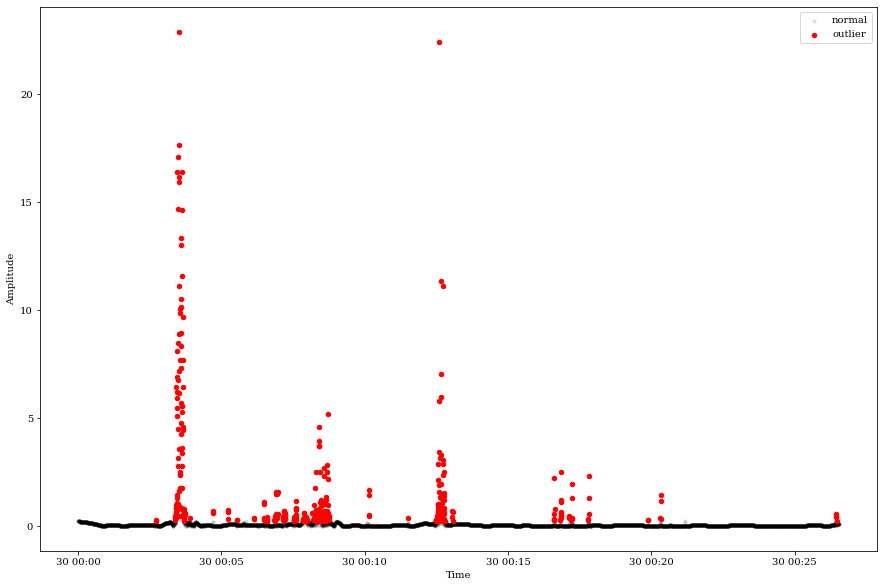

In [ ]:
print('Unseen Data plot')
plot_df(df3)

Confusion matrix and metrics for unseen data

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      7562
           1       0.30      0.26      0.28       405

    accuracy                           0.93      7967
   macro avg       0.63      0.61      0.62      7967
weighted avg       0.93      0.93      0.93      7967

Confusion matrix and metrics for unseen data

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7562
           1       0.21      0.32      0.26       405

    accuracy                           0.91      7967
   macro avg       0.59      0.63      0.60      7967
weighted avg       0.92      0.91      0.91      7967



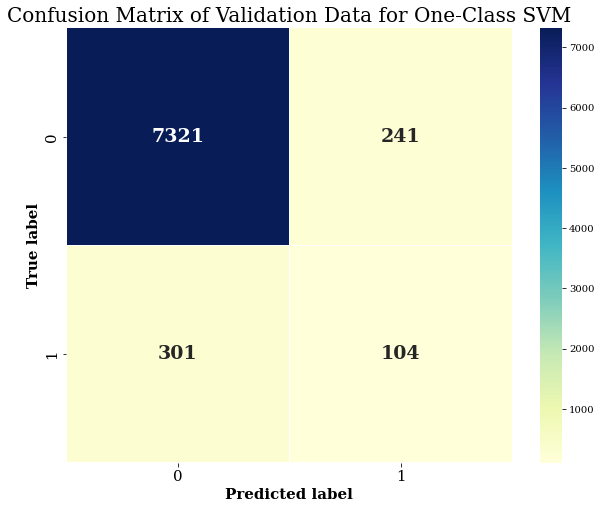

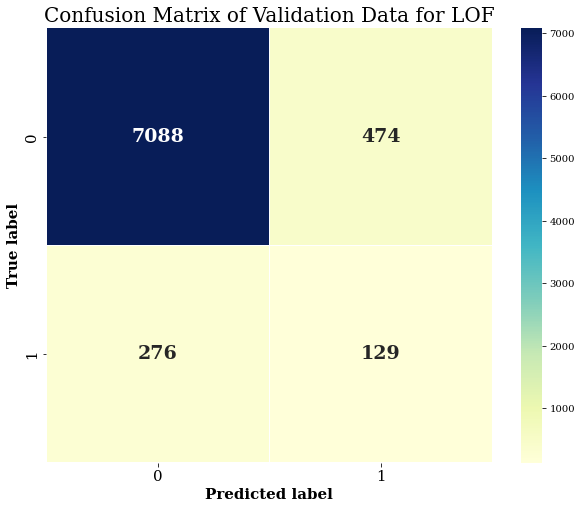

In [ ]:
print('Confusion matrix and metrics for unseen data\n')
conf_mat(df3['label'],pred_3,"Confusion Matrix of Validation Data for One-Class SVM")

print('Confusion matrix and metrics for unseen data\n')
conf_mat(df3['label'],lof_pred_3,"Confusion Matrix of Validation Data for LOF")

In [ ]:
reshaped_segments_3,labels_3 = create_data(df3)


In [ ]:
predictions = model.predict(reshaped_segments_3)

125/125 [==============================] - 1s 6ms/step


              precision    recall  f1-score   support

           0       1.00      0.97      0.99      3818
           1       0.61      0.94      0.74       161

    accuracy                           0.97      3979
   macro avg       0.80      0.96      0.86      3979
weighted avg       0.98      0.97      0.98      3979



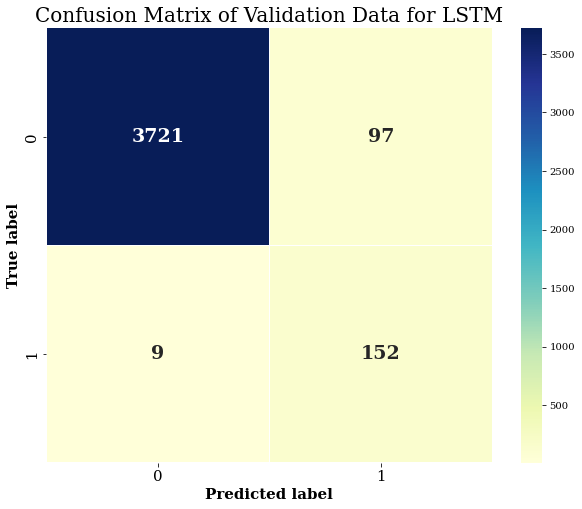

In [ ]:
max_act = np.argmax(labels_3,axis=1)
max_pred = np.argmax(predictions,axis=1)
conf_mat(max_act,max_pred,"Confusion Matrix of Validation Data for LSTM")

In [ ]:
X = df3.iloc[:,:-1]
X_svc = scaler.transform(X)

In [ ]:
pred_svc = svc.predict(X_svc)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      7562
           1       0.66      0.93      0.77       405

    accuracy                           0.97      7967
   macro avg       0.83      0.95      0.88      7967
weighted avg       0.98      0.97      0.97      7967



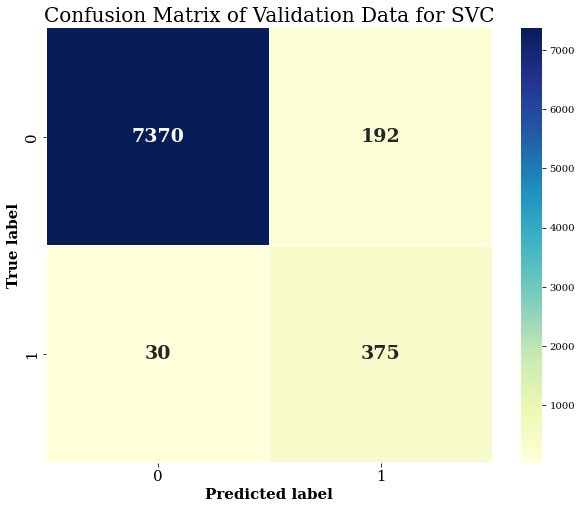

In [ ]:
conf_mat(df3['label'],pred_svc,"Confusion Matrix of Validation Data for SVC")

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes

In [ ]:
!cat /proc/meminfo

MemTotal:       13297228 kB
MemFree:         8673784 kB
MemAvailable:   11704444 kB
Buffers:           74396 kB
Cached:          2886980 kB
SwapCached:            0 kB
Active:           773272 kB
Inactive:        3626624 kB
Active(anon):        888 kB
Inactive(anon):  1181848 kB
Active(file):     772384 kB
Inactive(file):  2444776 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              3052 kB
Writeback:             0 kB
AnonPages:       1438448 kB
Mapped:           509348 kB
Shmem:              1164 kB
KReclaimable:     109904 kB
Slab:             140448 kB
SReclaimable:     109904 kB
SUnreclaim:        30544 kB
KernelStack:        4464 kB
PageTables:        26604 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6648612 kB
Committed_AS:    3255116 kB
VmallocTotal:   34359738367 kB
VmallocUsed:        9176 kB
VmallocChunk:          0 kB
Percpu:          